In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import tempmatch as tm
import obspy

import helpers

In [2]:
filelocs = !ls /media/sda/data/robdata/tremors/*.mseed

In [3]:
stream = obspy.read(filelocs[0])
for f in filelocs[1:]:
    stream = stream + obspy.read(f)

In [4]:
stream.merge(fill_value='latest')

6 Trace(s) in Stream:
7F.B00.02.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples
7F.B00.03.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.898000Z | 10.0 Hz, 240304060 samples
7F.B00.04.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples
7F.B00.05.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples
7F.B00.06.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.898000Z | 10.0 Hz, 240304060 samples
7F.B00.01.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples

In [5]:
# stream.write('/media/sda/data/robdata/tremors/alldata.mseed', type='MSEED')

In [6]:
h1 = stream[0].copy()

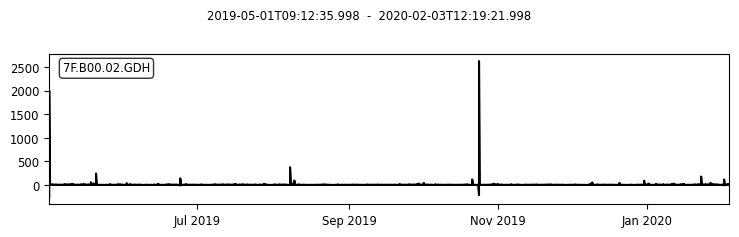

In [7]:
x = h1.plot()

In [8]:
# h1.plot(starttime=obspy.UTCDateTime('2019-10-24T06:00:00'), endtime=obspy.UTCDateTime('2019-10-24T08:00:00'))

In [9]:
y = h1.data
y = y.cumsum()

In [10]:
detectfiles = !ls /media/sda/data/borehole/detections/*.csv

In [11]:

def read_csvs_convert_to_dataframe(csv_paths):
    """
    reads a list of csv file locations and returns them
    as a pandas dataframe
    """
    df = pd.DataFrame()
    for f in csv_paths:
        try:
            df = pd.concat([df, pd.read_csv(f)])
        except:
            pass
        
    return df

bubble = read_csvs_convert_to_dataframe(detectfiles)
bubble['time'] = pd.to_datetime(bubble['time'])
bubble.sort_values(by='time', inplace=True)
bubble['ones'] = 1
bubble.set_index('time', inplace=True)

In [12]:
from hydrophone_data_processing import preprocessing, load
preprocessing.calculate_quiet_noise()

[0.00041850735020222441,
 0.00046972312781760591,
 0.0013195026222848629,
 0.00021643569329829595,
 0.0004857136968939755,
 0.0011491940782770648]

In [13]:
# 279 days of hydrophone deployment
h1.stats

         network: 7F
         station: B00
        location: 02
         channel: GDH
       starttime: 2019-05-01T09:12:35.998000Z
         endtime: 2020-02-03T12:19:21.998000Z
   sampling_rate: 10.0
           delta: 0.1
            npts: 240304061
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1055, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 25927680})

In [14]:
integrated_noise = (np.ones([279*24//2, 6]) * preprocessing.calculate_quiet_noise()).cumsum(axis=1)

In [15]:
xnoise = pd.date_range(start='2019-05-01T09:00:00', end='2020-02-03T12:00:00', freq='2h')
xnoise

DatetimeIndex(['2019-05-01 09:00:00', '2019-05-01 11:00:00',
               '2019-05-01 13:00:00', '2019-05-01 15:00:00',
               '2019-05-01 17:00:00', '2019-05-01 19:00:00',
               '2019-05-01 21:00:00', '2019-05-01 23:00:00',
               '2019-05-02 01:00:00', '2019-05-02 03:00:00',
               ...
               '2020-02-02 17:00:00', '2020-02-02 19:00:00',
               '2020-02-02 21:00:00', '2020-02-02 23:00:00',
               '2020-02-03 01:00:00', '2020-02-03 03:00:00',
               '2020-02-03 05:00:00', '2020-02-03 07:00:00',
               '2020-02-03 09:00:00', '2020-02-03 11:00:00'],
              dtype='datetime64[ns]', length=3338, freq='2H')

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))

for h in stream:
    h = h.copy()
    h.integrate()
    ax.plot(h.times('matplotlib'), h.data)
    station_name = h.stats.station + '.' + h.stats.location
    # ax.plot(tr.times(), tr.data)
    ax.text(s=station_name, x=18400, y=h.data.max()
           ,fontsize=15)
    
ax.set_ylabel('cumulative amplitude 5-10Hz bandpass', fontsize=15)

Text(0, 0.5, 'cumulative amplitude 5-10Hz bandpass')

MemoryError: Unable to allocate 3.58 GiB for an array with shape (2, 240304061) and data type float64

<Figure size 1080x360 with 1 Axes>

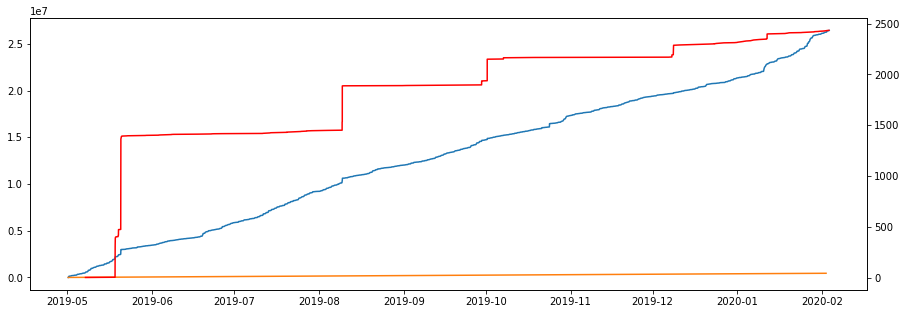

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(h1.times('matplotlib'), y)
# ax.plot(h1.times(), y)

times = []
maxes = []
for h in h1.slide(window_length=86400, step=86400):
    maxes.append(h.integrate().max())
    times.append(h.stats.starttime.matplotlib_date)
minmax = min(maxes)

noise_integrate = np.zeros_like(times)
noise_integrate = noise_integrate + minmax
noise_integrate = noise_integrate.cumsum()

ax.plot(times, noise_integrate)

ax2 = ax.twinx()
y2 = bubble.ones.cumsum()
x2 = pd.to_datetime(bubble.index)
ax2.plot(x2, y2, color='red')


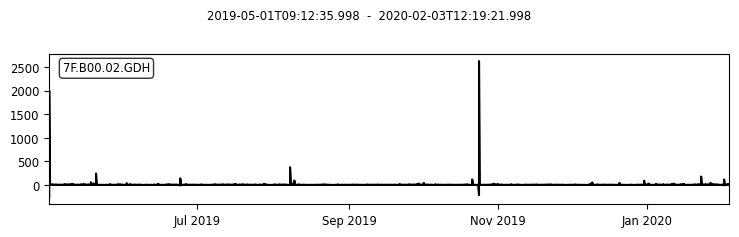

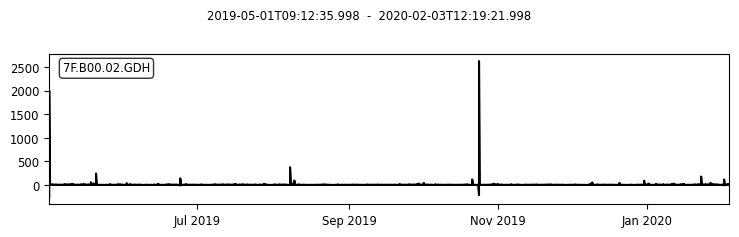

In [49]:
h1.plot()

In [40]:
h1.times()

array([  0.00000000e+00,   1.00000000e-01,   2.00000000e-01, ...,
         2.40304058e+07,   2.40304059e+07,   2.40304060e+07])

In [28]:
maxes_per_day = [h.integrate().max() for h in h1.slide(window_length=86400, step=86400)]

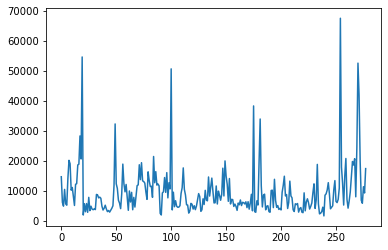

In [30]:
plt.plot(maxes_per_day)

In [32]:
min(maxes_per_day)

1605.4055324169935

In [111]:
import scipy.signal as signal

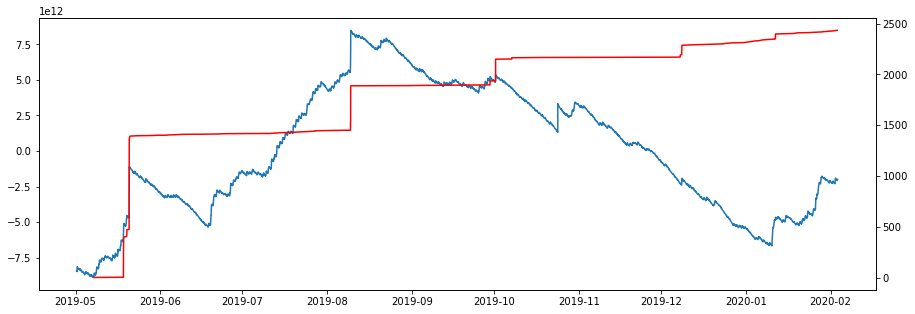

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))

# ax.plot(pd.to_datetime(h1.times()+bubble.index[0].value), y)
ax.plot(h1.times('matplotlib'), signal.detrend(y))
# ax.set_yscale('log')

# fig, ax = plt.subplots(figsize=(15, 5))

# df['cumsum'].plot(ax=ax, color='dodgerblue')
ax2 = ax.twinx()
y2 = bubble.ones.cumsum()
x2 = pd.to_datetime(bubble.index)
ax2.plot(x2, y2, color='red')
# ax.set_yscale('log')

In [132]:
stream

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples (masked)
7F.B00.02.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples (masked)
7F.B00.03.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.898000Z | 10.0 Hz, 240304060 samples (masked)
7F.B00.04.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples (masked)
7F.B00.05.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.998000Z | 10.0 Hz, 240304061 samples (masked)
7F.B00.06.GDH | 2019-05-01T09:12:35.998000Z - 2020-02-03T12:19:21.898000Z | 10.0 Hz, 240304060 samples (masked)

In [ ]:
fig, ax = plt. subplots(figsize=(15, 5))

for n, tr in enumerate(stream):
    
    t = tr.times('matplotlib')
    y = tr.data.cumsum()
    
    ax.plot(y, t, label='h{n}'.format(n=n))
    
ax.legend()
fig.savefig('plots.pdf', bbox_inches='tight')
plt.close()
print('i finished your figure for you')

In [97]:
# h1.stats

         network: 7F
         station: B00
        location: 01
         channel: GDH
       starttime: 2019-05-01T09:12:35.998000Z
         endtime: 2020-02-03T12:19:21.998000Z
   sampling_rate: 10.0
           delta: 0.1
            npts: 240304061
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1055, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 25927680})

In [91]:
# h1.times()

masked_array(data = [0.0 0.1 0.2 ..., 24030405.8 24030405.9 24030406.0],
             mask = [False False False ..., False False False],
       fill_value = 1e+20)

In [55]:
# pd.to_datetime(h1.times()+bubble.index[0].value)

DatetimeIndex(['2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               '2019-05-07 16:37:35.302000896',
               ...
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360',
               '2019-05-07 16:37:35.326031360'],
              dtype=

In [73]:
# pd.to_datetime(h1.times()[-1], unit='ms')

Timestamp('1970-01-01 06:40:30.406000')

In [92]:
# bubble.index[0]

Timestamp('2019-05-07 16:37:35.302001+0000', tz='UTC')

In [96]:
# pd.to_datetime(h1.times()[-1]+1557247055000000000, origin='unix', unit='ns')

Timestamp('2019-05-07 16:37:35.024030464')